## Long short-term memory neural network for stock price prediction

Reference: https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb#scrollTo=7FYBJCDW5nBr

This tutorial will cover: 1) introduction to PyTorch; 2) building a simple neural network with PyTorch; 3) implementation of LSTM with PyTorch for the stock price prediction.

PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR). A number of pieces of deep learning software are built on top of PyTorch, including Tesla Autopilot, Uber's Pyro, Hugging Face's Transformers, PyTorch Lightning, and Catalyst. -- From Wiki

We will start with reviewing the very basic concepts of PyTorch. As a prerequisite, we recommend to be familiar with the numpy package as most machine learning frameworks are based on very similar concepts. Pytorch is easy to install and here is a tutorial: https://pytorch.org/. After you install it, you can check its version.

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
print("Using torch", torch.__version__)

Using torch 1.12.1


### Tensors

Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration (more on that later).
The name "tensor" is a generalization of concepts you already know. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.
#### Initialization

Let's first start by looking at different ways of creating a tensor. There are many possible options, the most simple one is to call `torch.Tensor` passing the desired shape as input argument:

In [66]:
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[4.2521e-38, 1.4013e-45, 4.2520e-38, 1.4013e-45],
         [4.2520e-38, 1.4013e-45, 7.4713e-37, 1.4013e-45],
         [7.2440e-37, 1.4013e-45, 4.8415e-38, 1.4013e-45]],

        [[4.3494e-38, 1.4013e-45, 4.6268e-38, 1.4013e-45],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]])


In [67]:
# Create a tensor from a (nested) list
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


#### Tensor to Numpy, and Numpy to Tensor

Tensors can be converted to numpy arrays, and numpy arrays back to tensors. To transform a numpy array into a tensor, we can use the function `torch.from_numpy`:

In [68]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


In [69]:
# Question: how to transform a PyTorch tensor back to a numpy array. Hint: we can use the function .numpy() on tensors:
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

PyTorch tensor: tensor([[1, 2],
        [3, 4]])
Numpy array: [[1 2]
 [3 4]]


#### Operations

Most operations that exist in numpy, also exist in PyTorch. A full list of operations can be found in the [PyTorch documentation](https://pytorch.org/docs/stable/tensors.html#), but we will review the most important ones here.

The simplest operation is to add two tensors:

In [70]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

# Question: use a square operation for x1
y = torch.square(x1)
print("Squred x1", y)

X1 tensor([[0.6949, 0.7202, 0.1080],
        [0.4933, 0.0906, 0.1252]])
X2 tensor([[0.3028, 0.7693, 0.7916],
        [0.5121, 0.1516, 0.6043]])
Y tensor([[0.9977, 1.4895, 0.8996],
        [1.0054, 0.2422, 0.7295]])
Squred x1 tensor([[0.4829, 0.5187, 0.0117],
        [0.2433, 0.0082, 0.0157]])


## Learning by example: Continuous XOR

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called `torch.nn` that makes building neural networks more convenient. 

We will introduce the libraries and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function.
Hence, we will learn how to build a small neural network that can learn this function. 
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. 

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

In [71]:
import torch.nn as nn

#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [72]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

The forward function is where the computation of the module is taken place, and is executed when you call the module (`nn = MyModule(); nn(x)`). In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. 
In PyTorch, we can define this as follows:

In [73]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [74]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

# Question: build a new neural network with five input neurons and seven hidden neurons for binary classification.
model_new = SimpleClassifier(num_inputs=5, num_hidden=7, num_outputs=1)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [75]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [76]:
# Question: Printing the new model lists all submodules it contains.
for name, param in model_new.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([7, 5])
Parameter linear1.bias, shape torch.Size([7])
Parameter linear2.weight, shape torch.Size([1, 7])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there. 

In [77]:
import torch.utils.data as data

In [78]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [79]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.0610, 0.1759]), tensor(0))


In [80]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

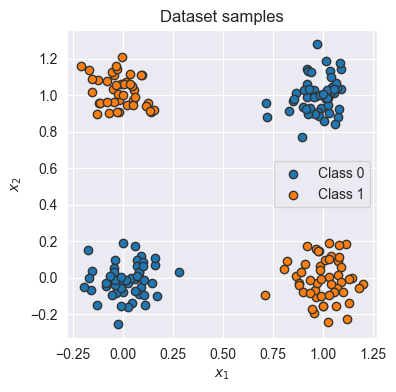

In [81]:
visualize_samples(dataset.data, dataset.label)
plt.show()

Let's create a simple data loader below:

In [82]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [83]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the 
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.0219,  0.9470],
        [ 0.1257,  0.9565],
        [ 0.1018,  0.0637],
        [-0.0085,  1.0612],
        [ 0.0502,  0.9447],
        [ 0.0820,  0.0333],
        [ 1.0372,  1.1316],
        [ 1.1298, -0.0052]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 1, 1, 0, 0, 1])


### Optimization

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$.

In [84]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent

In [85]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# Question: Instead of SGD, use Adam as an new optimizer: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer_new = torch.optim.Adam(model.parameters(), lr=0.1)

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

In [86]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [87]:
# Push model to device. Has to be only done once
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [88]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [89]:
## Progress bar
from tqdm.notebook import tqdm

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

In [90]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [91]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

In [92]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [93]:
eval_model(model, test_data_loader)

Accuracy of the model: 99.80%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

## Long short-term memory (LSTM)

In [94]:
import pandas as pd 

In [95]:
filepath = 'AMZN.csv'
data = pd.read_csv(filepath, parse_dates=['Date'], index_col=['Date'], dayfirst=True)
data = data.sort_values('Date')
data.head()
data.shape

(251, 1)

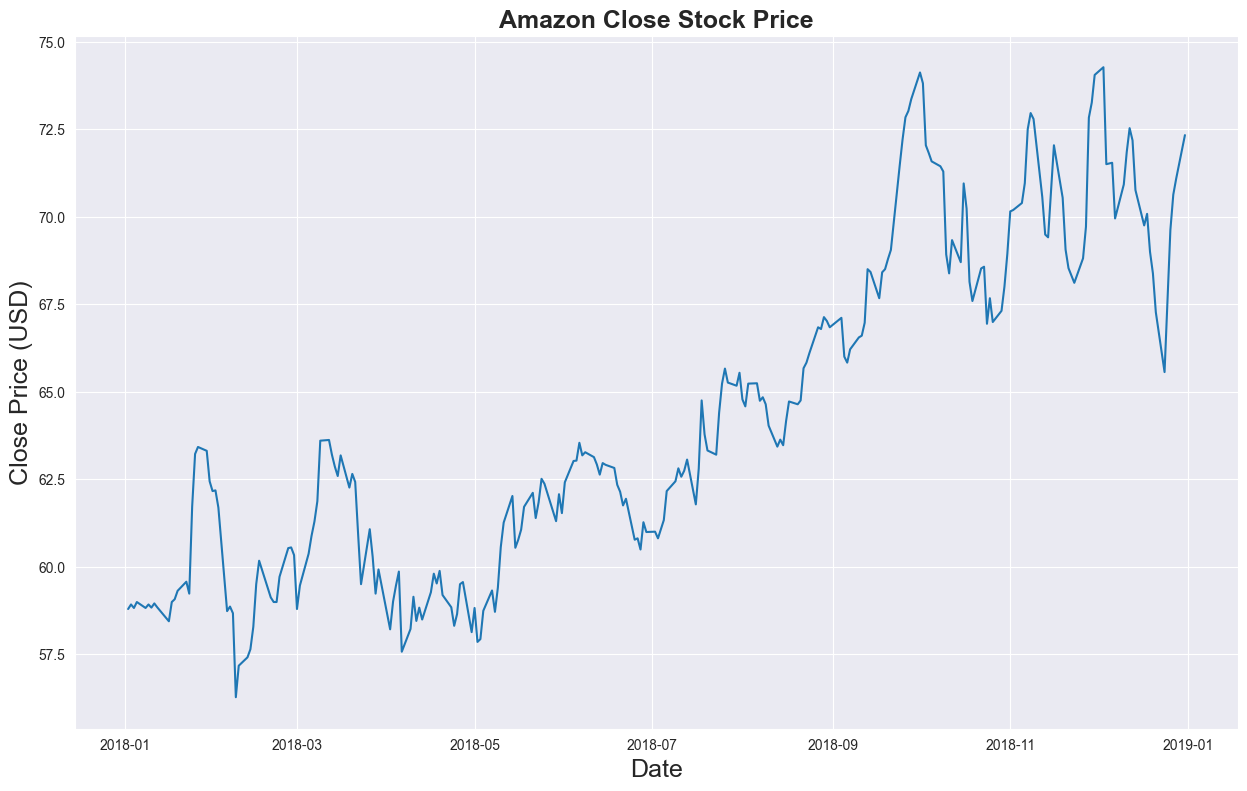

In [96]:
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
# data[['Close']]
plt.plot(data[['Close']])
# plt.xticks(range(0,data.shape[0],250),data['Date'].loc[::250],rotation=45)
plt.title("Amazon Close Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

## Normalize data

In [97]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-02 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   251 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [98]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [99]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    # feature construction: create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [100]:
lookback = 20 # choose sequence length to generate lag features
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (185, 19, 1)
y_train.shape =  (185, 1)
x_test.shape =  (46, 19, 1)
y_test.shape =  (46, 1)


In [101]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [114]:
# set a list of hyperparameters

# The number of expected features in the input 
input_dim = 1
# The number of features in the hidden state
hidden_dim = 32
# Number of recurrent layers
num_layers = 2
# The number of expected features in the output
output_dim = 1
# The number of epochs
num_epochs = 100

# For the below two questions, there is no a very strict answer to it. But one thing you need to consider is overfitting.
# Question: with increasing the number of features in the hidden state (e.g., 64, 128), what will the performance of LSTM be like?
# hidden_dim = 64

# Question: with increasing the number of epochs (e.g., 200, 400), what will the performance of LSTM be like?
# num_epochs = 200

In [115]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [116]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [117]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.26621192693710327
Epoch  1 MSE:  0.19931669533252716
Epoch  2 MSE:  0.1683993637561798
Epoch  3 MSE:  0.17046624422073364
Epoch  4 MSE:  0.13537870347499847
Epoch  5 MSE:  0.11938631534576416
Epoch  6 MSE:  0.10063901543617249
Epoch  7 MSE:  0.06313934177160263
Epoch  8 MSE:  0.10534127056598663
Epoch  9 MSE:  0.0398346446454525
Epoch  10 MSE:  0.06589376926422119
Epoch  11 MSE:  0.0687386617064476
Epoch  12 MSE:  0.04615340381860733
Epoch  13 MSE:  0.027365639805793762
Epoch  14 MSE:  0.028428588062524796
Epoch  15 MSE:  0.038351502269506454
Epoch  16 MSE:  0.03944063559174538
Epoch  17 MSE:  0.03329097479581833
Epoch  18 MSE:  0.028716059401631355
Epoch  19 MSE:  0.02817029133439064
Epoch  20 MSE:  0.029591696336865425
Epoch  21 MSE:  0.030654726549983025
Epoch  22 MSE:  0.030179889872670174
Epoch  23 MSE:  0.028034545481204987
Epoch  24 MSE:  0.024859340861439705
Epoch  25 MSE:  0.021859362721443176
Epoch  26 MSE:  0.02029453031718731
Epoch  27 MSE:  0.0204979050904

In [118]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

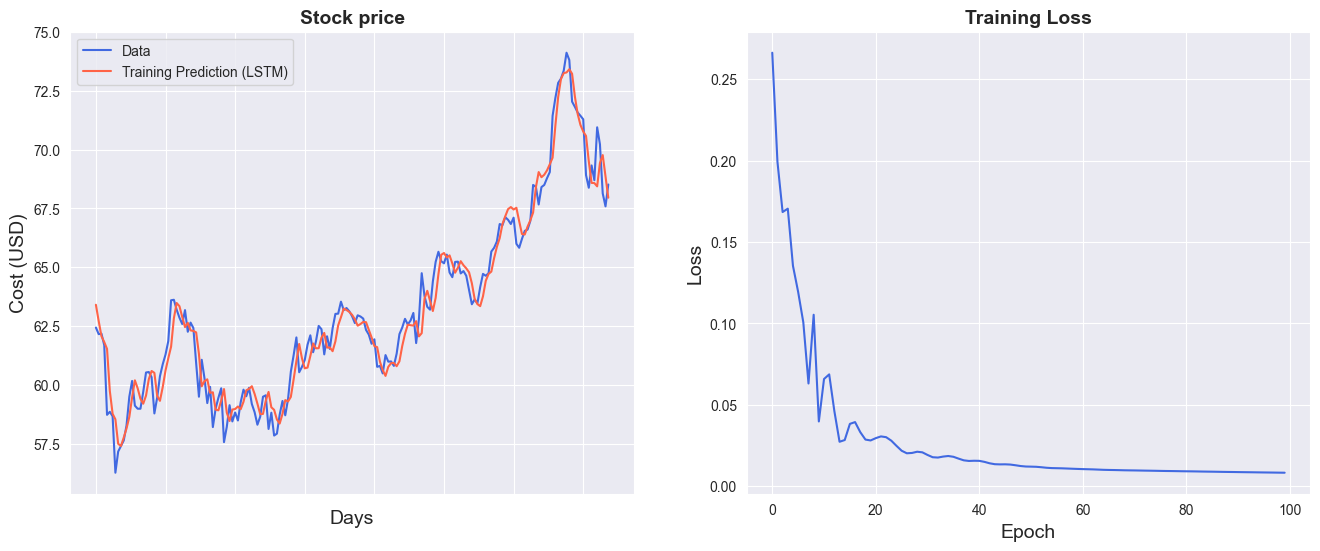

In [119]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [120]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.82 RMSE
Test Score: 1.49 RMSE


In [121]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [122]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()